In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import skewtest

In [66]:
import pandas as pd

data = pd.read_csv("/Users/tomcooklin/Desktop/subset.csv")

data = data.iloc[: , 3:]

data = data.rename(columns={"REGION.x": "REGION", "ST.x": "ST", "ADJINC.x": "ADJINC", "PUMA.x": "PUMA"})

data.head()

,SERIALNO,REGION,ST,HINCP,ADJINC,WGTP,PWGTP,AGEP,RAC1P,RAC2P,RACBLK,RACWHT,RELSHIPP,SEX,PINCP,PUMA,INCOME
0,2021GQ0000001,4,4,NaN,1029928,0,35,36,White,1,0,1,37,1,1050,800,1081.4244
1,2021GQ0000002,2,26,NaN,1029928,0,35,19,White,1,0,1,38,1,3000,1002,3089.7840
2,2021GQ0000003,2,39,NaN,1029928,0,70,57,White,1,0,1,37,1,9300,1802,9578.3304
3,2021GQ0000005,4,6,NaN,1029928,0,177,26,White,1,0,1,38,1,15000,3741,15448.9200
4,2021GQ0000006,4,6,NaN,1029928,0,14,80,White,1,0,1,37,2,14800,11102,15242.9344


## Determing whether to use mean income or median income

In [68]:
def round_to_nearest_1000(x):
    return round(x/1000) * 1000

data = data[data['INCOME'].notna()]

data['rounded_income'] = data['INCOME'].apply(round_to_nearest_1000)

In [69]:
max(data["INCOME"])

1652725.0

In [70]:
skewtest(data.dropna()["INCOME"])

SkewtestResult(statistic=1241.8421807393593, pvalue=0.0)

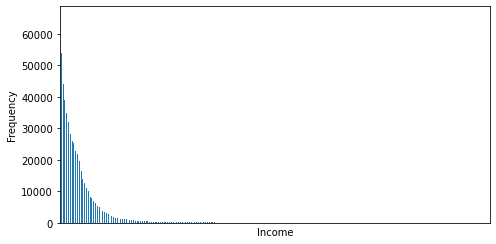

In [71]:
plt.rcParams["figure.figsize"] = [7, 3.5]
plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots()

data['rounded_income'].value_counts().plot(ax=ax, kind='bar', xlabel='Income', ylabel='Frequency')

plt.xticks([]) 

plt.show()

Since income is skewed, it is best to use median.

In [72]:
# wm = lambda x: np.average(x, weights=data.loc[x.index, "PWGTP"])
# pincp_data = data.groupby(["PUMA"]).agg(WGTP=("PWGTP", "sum"), weighted_mean=("PINCP", wm))

pincp_data = data.groupby('PUMA').agg({'INCOME':np.median}).reset_index()

pincp_data.head()

,PUMA,INCOME
0,100,30897.84
1,101,33987.62
2,102,41197.12
3,103,41197.12
4,104,35017.55


In [73]:
pincp_data.rename(columns={"INCOME": "income_median_PUMA"}, inplace = True)

pincp_data.head()

,PUMA,income_median_PUMA
0,100,30897.84
1,101,33987.62
2,102,41197.12
3,103,41197.12
4,104,35017.55


In [74]:
data.head()

,SERIALNO,REGION,ST,HINCP,ADJINC,WGTP,PWGTP,AGEP,RAC1P,RAC2P,RACBLK,RACWHT,RELSHIPP,SEX,PINCP,PUMA,INCOME,rounded_income
0,2021GQ0000001,4,4,NaN,1029928,0,35,36,White,1,0,1,37,1,1050,800,1081.4244,1000
1,2021GQ0000002,2,26,NaN,1029928,0,35,19,White,1,0,1,38,1,3000,1002,3089.7840,3000
2,2021GQ0000003,2,39,NaN,1029928,0,70,57,White,1,0,1,37,1,9300,1802,9578.3304,10000
3,2021GQ0000005,4,6,NaN,1029928,0,177,26,White,1,0,1,38,1,15000,3741,15448.9200,15000
4,2021GQ0000006,4,6,NaN,1029928,0,14,80,White,1,0,1,37,2,14800,11102,15242.9344,15000


In [75]:
data = data.merge(pincp_data, on='PUMA', how='left')

data.head()

,SERIALNO,REGION,ST,HINCP,ADJINC,WGTP,PWGTP,AGEP,RAC1P,RAC2P,RACBLK,RACWHT,RELSHIPP,SEX,PINCP,PUMA,INCOME,rounded_income,income_median_PUMA
0,2021GQ0000001,4,4,NaN,1029928,0,35,36,White,1,0,1,37,1,1050,800,1081.4244,1000,30897.84
1,2021GQ0000002,2,26,NaN,1029928,0,35,19,White,1,0,1,38,1,3000,1002,3089.7840,3000,36047.48
2,2021GQ0000003,2,39,NaN,1029928,0,70,57,White,1,0,1,37,1,9300,1802,9578.3304,10000,38519.31
3,2021GQ0000005,4,6,NaN,1029928,0,177,26,White,1,0,1,38,1,15000,3741,15448.9200,15000,23688.34
4,2021GQ0000006,4,6,NaN,1029928,0,14,80,White,1,0,1,37,2,14800,11102,15242.9344,15000,39291.75


In [76]:
data["income_percent"] = data["INCOME"] / data["income_median_PUMA"]

data.head()

,SERIALNO,REGION,ST,HINCP,ADJINC,WGTP,PWGTP,AGEP,RAC1P,RAC2P,RACBLK,RACWHT,RELSHIPP,SEX,PINCP,PUMA,INCOME,rounded_income,income_median_PUMA,income_percent
0,2021GQ0000001,4,4,NaN,1029928,0,35,36,White,1,0,1,37,1,1050,800,1081.4244,1000,30897.84,0.035000
1,2021GQ0000002,2,26,NaN,1029928,0,35,19,White,1,0,1,38,1,3000,1002,3089.7840,3000,36047.48,0.085714
2,2021GQ0000003,2,39,NaN,1029928,0,70,57,White,1,0,1,37,1,9300,1802,9578.3304,10000,38519.31,0.248663
3,2021GQ0000005,4,6,NaN,1029928,0,177,26,White,1,0,1,38,1,15000,3741,15448.9200,15000,23688.34,0.652174
4,2021GQ0000006,4,6,NaN,1029928,0,14,80,White,1,0,1,37,2,14800,11102,15242.9344,15000,39291.75,0.387942


## Exploratory

### doing on R instead

In [77]:
explo = data[['RAC1P', 'INCOME']]

explo.head()

,RAC1P,INCOME
0,White,1081.4244
1,White,3089.7840
2,White,9578.3304
3,White,15448.9200
4,White,15242.9344


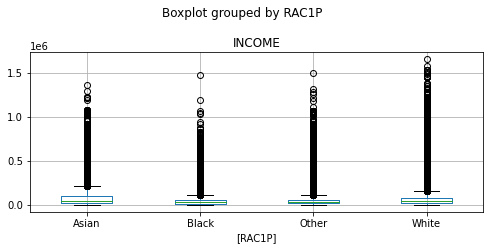

In [78]:
boxplot = explo.boxplot(by='RAC1P')

In [79]:
explo = data[['RAC1P', 'income_percent']]

explo.head()

,RAC1P,income_percent
0,White,0.035000
1,White,0.085714
2,White,0.248663
3,White,0.652174
4,White,0.387942


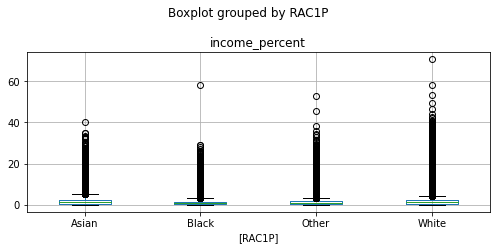

In [80]:
boxplot = explo.boxplot(by='RAC1P')

## Modelling Section

In [14]:
data.isna().sum()

SERIALNO                   0
REGION                     0
ST                         0
HINCP                 101626
ADJINC                     0
WGTP                       0
PWGTP                      0
AGEP                       0
RAC1P                      0
RAC2P                      0
RACBLK                     0
RACWHT                     0
RELSHIPP                   0
SEX                        0
PINCP                      0
PUMA                       0
INCOME                     0
rounded_income             0
income_median_PUMA         0
income_percent             0
dtype: int64

In [82]:
from statsmodels.formula.api import ols

data2=data.dropna(subset=['AGEP', 'RACBLK', 'RACWHT', 'SEX', 'income_percent'])

X = data2[['AGEP', 'RACBLK', 'RACWHT', 'SEX']]
y = data2[['income_percent']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

model = ols(formula='income_percent ~ AGEP + RACBLK + RACWHT + SEX', data=data2)
print(type(model))

<class 'statsmodels.regression.linear_model.OLS'>


In [83]:
model = model.fit()
print(type(model))
print(model.summary() )

<class 'statsmodels.regression.linear_model.RegressionResultsWrapper'>
                            OLS Regression Results                            
Dep. Variable:         income_percent   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                 2.055e+04
Date:                Sat, 18 Mar 2023   Prob (F-statistic):               0.00
Time:                        13:08:52   Log-Likelihood:            -4.9414e+06
No. Observations:             2388259   AIC:                         9.883e+06
Df Residuals:                 2388254   BIC:                         9.883e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

In [84]:
modelpredictions = pd.DataFrame( columns=['income_percentLM'], data= model.predict(data2)) 

In [85]:
print(modelpredictions.shape)

(2388259, 1)


In [86]:
print(modelpredictions.head())

   income_percentLM
0          1.787551
1          1.688908
2          1.909405
3          1.729526
4          1.424986


# Community Approach

In [87]:
def gini(x):
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))

grouped = data.groupby(['PUMA'])

gini_index = grouped['INCOME'].apply(gini).reset_index()

gini_index.rename(columns={"INCOME": "gini_index"}, inplace = True)

gini_index.head()

,PUMA,gini_index
0,100,0.510670
1,101,0.589754
2,102,0.538226
3,103,0.557650
4,104,0.500416


In [98]:
com2 = data[['PUMA', 'RAC1P', 'income_percent']]

com2.head()

,PUMA,RAC1P,income_percent
0,800,White,0.035000
1,1002,White,0.085714
2,1802,White,0.248663
3,3741,White,0.652174
4,11102,White,0.387942


In [125]:
com3 = com2.groupby(['RAC1P', 'PUMA'])['RAC1P'].count()
com3 = com3.to_frame().rename(columns={'RAC1P': 'count'}).reset_index()
com3.head()

,RAC1P,PUMA,count
0,Asian,100,1149
1,Asian,101,847
2,Asian,102,941
3,Asian,103,692
4,Asian,104,306


In [126]:
com4 = com2.groupby(['PUMA'])['RAC1P'].count()

com4 = com4.to_frame()

com4.head()

,RAC1P
PUMA,
100,50573
101,15020
102,16383
103,12712
104,8732


In [130]:
com5 = com3.merge(com4, on='PUMA', how='left')
com5.head()

,RAC1P_x,PUMA,count,RAC1P_y
0,Asian,100,1149,50573
1,Asian,101,847,15020
2,Asian,102,941,16383
3,Asian,103,692,12712
4,Asian,104,306,8732


In [131]:
com5['PER'] = com5['count'] / com5['RAC1P_y']
com5.head()

,RAC1P_x,PUMA,count,RAC1P_y,PER
0,Asian,100,1149,50573,0.022720
1,Asian,101,847,15020,0.056391
2,Asian,102,941,16383,0.057438
3,Asian,103,692,12712,0.054437
4,Asian,104,306,8732,0.035044


In [132]:
com5.sort_values(by=['PUMA'])

,RAC1P_x,PUMA,count,RAC1P_y,PER
0,Asian,100,1149,50573,0.022720
2943,White,100,41273,50573,0.816107
1961,Other,100,6526,50573,0.129041
979,Black,100,1625,50573,0.032132
2944,White,101,10740,15020,0.715047
...,...,...,...,...,...
1959,Black,70201,5,819,0.006105
1960,Black,70301,8,628,0.012739
2942,Other,70301,44,628,0.070064
978,Asian,70301,20,628,0.031847


In [133]:
com5.rename(columns={"RAC1P_x": "RAC1P"}, inplace = True)
com5 = com5[['RAC1P', 'PUMA', 'PER']]
com5.head()

,RAC1P,PUMA,PER
0,Asian,100,0.022720
1,Asian,101,0.056391
2,Asian,102,0.057438
3,Asian,103,0.054437
4,Asian,104,0.035044


In [135]:
com5 = pd.pivot(com5, index=['PUMA'], columns = 'RAC1P',values = 'PER')

com5.head()

RAC1P,Asian,Black,Other,White
PUMA,,,,
100,0.022720,0.032132,0.129041,0.816107
101,0.056391,0.092277,0.136285,0.715047
102,0.057438,0.101264,0.138924,0.702374
103,0.054437,0.096602,0.162524,0.686438
104,0.035044,0.184379,0.148305,0.632272


In [139]:
com5 = pd.merge(gini_index, com5,  how='left', left_on=['PUMA'], right_on = ['PUMA'])

com5 = com.dropna()

com5.sort_values(by=['PUMA'])

,PUMA,gini_index,Asian,Black,Other,White
0,100,0.510670,0.022720,0.032132,0.129041,0.816107
1,101,0.589754,0.056391,0.092277,0.136285,0.715047
2,102,0.538226,0.057438,0.101264,0.138924,0.702374
3,103,0.557650,0.054437,0.096602,0.162524,0.686438
4,104,0.500416,0.035044,0.184379,0.148305,0.632272
...,...,...,...,...,...,...
977,59308,0.531108,0.207378,0.026919,0.100698,0.665005
978,59309,0.502377,0.274905,0.059269,0.129887,0.535939
979,70101,0.524368,0.021080,0.003953,0.043478,0.931489
980,70201,0.524909,0.061050,0.006105,0.052503,0.880342


In [137]:
for col in com.columns:
    print(col)

PUMA
gini_index
Asian
Black
Other
White


In [25]:
com.rename(columns={1.0: "white", 2.0: "afr", 3.0: "ind", 4.0: "alask", 5.0: "ind_nat", 6.0: "asian", 7.0: "hawaii", 8.0: "other", 9.0: "two"}, inplace = True)

com.head()

,PUMA,gini_index,white,afr,ind,alask,ind_nat,asian,hawaii,other,two
0,100.0,0.510670,0.426683,0.033599,0.058927,0.000579,0.007288,0.071271,0.018598,0.072201,0.310855
1,101.0,0.589754,0.301102,0.077715,0.005551,0.004486,0.001402,0.142477,0.008831,0.139505,0.318932
2,102.0,0.538226,0.291871,0.084160,0.005174,0.005682,0.001522,0.143209,0.005327,0.148941,0.314115
3,103.0,0.557650,0.269454,0.075840,0.011487,0.000618,0.002007,0.128211,0.002810,0.172184,0.337389
5,105.0,0.526840,0.278919,0.077118,0.003951,0.000421,0.003161,0.216498,0.008850,0.132322,0.278761


In [141]:
model = ols(formula='gini_index ~ Asian + Black + White + Other', data=com5)
print(type(model))

<class 'statsmodels.regression.linear_model.OLS'>


In [142]:
model = model.fit()
print(type(model))
print(model.summary())

<class 'statsmodels.regression.linear_model.RegressionResultsWrapper'>
                            OLS Regression Results                            
Dep. Variable:             gini_index   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     33.95
Date:                Sat, 18 Mar 2023   Prob (F-statistic):           7.10e-21
Time:                        14:13:15   Log-Likelihood:                 1877.4
No. Observations:                 979   AIC:                            -3747.
Df Residuals:                     975   BIC:                            -3727.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

Does not yield any useful information which makes sense. We should not expect to that with the percentage of black individuals increasing in a community, the income inequality to increase. Whilst this community may have a lower income, this doesn't infer that the income is distributed unevenly. Another question might be: what racial composition of a community has the most income inequality?